In [2]:
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
import matplotlib.pyplot as plt
import numpy as np
import scipy
from matplotlib.patches import FancyArrowPatch
from sklearn.decomposition import PCA
from dca_research.lqg import LQGComponentsAnalysis as LQGCA

In [3]:
class Arrow3D(FancyArrowPatch):

    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0, 0), (0, 0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0], ys[0]), (xs[1], ys[1]))
        FancyArrowPatch.draw(self, renderer)

In [4]:
from matplotlib.patches import ArrowStyle

In [5]:
import pdb

In [6]:
from scipy.ndimage import gaussian_filter1d

In [7]:
from copy import deepcopy

In [8]:
# Generate a trajectory in 3D space 
def gen_trajectory(sigma, nt):

    # Produce radial motion with graduall increasing radius
    t = np.linspace(0, 1, nt)

    # Produce this motion in the xy plane and then later rotate it out of plane
    r = np.multiply(t, np.ones(t.size))
    th = np.linspace(0, 4. * np.pi, t.size)
    x = np.multiply(r, np.cos(th))
    y = np.multiply(r, np.sin(th))
    z = t

    # Rotate the spiral
    phi = np.pi/4
    R = np.array([[1, 0, 0], [0, np.cos(phi), -np.sin(phi)], [0, np.sin(phi), np.cos(phi)]])    

    d = np.concatenate([np.array([x[k], y[k], z[k]])[np.newaxis, :] @ R for k in range(t.size)])

    y = deepcopy(d)
    # Add noise in the perpendicular direction    
    noise_perp = np.zeros(y.shape)
    for i in range(1, nt):
        noise = np.random.normal(scale=sigma, size=(3,))
        # Project onto the plane perpendicular to the straight line
        vec = d[i, :] - d[i - 1, :]
        noise_perp[i, :] = noise - np.dot(noise, vec)/np.dot(vec, vec) * vec

    # high pass filter the noise
    sos = scipy.signal.butter(10, 5, 'hp', fs=1000, output='sos')
    #y += gaussian_filter1d(noise_perp, sigma=5, axis=0)
    y += scipy.signal.sosfilt(sos, noise_perp)
    # Smooth
    #y += noise_perp
    #y = gaussian_filter1d(y, sigma=3., axis=0)
    return t, y, d

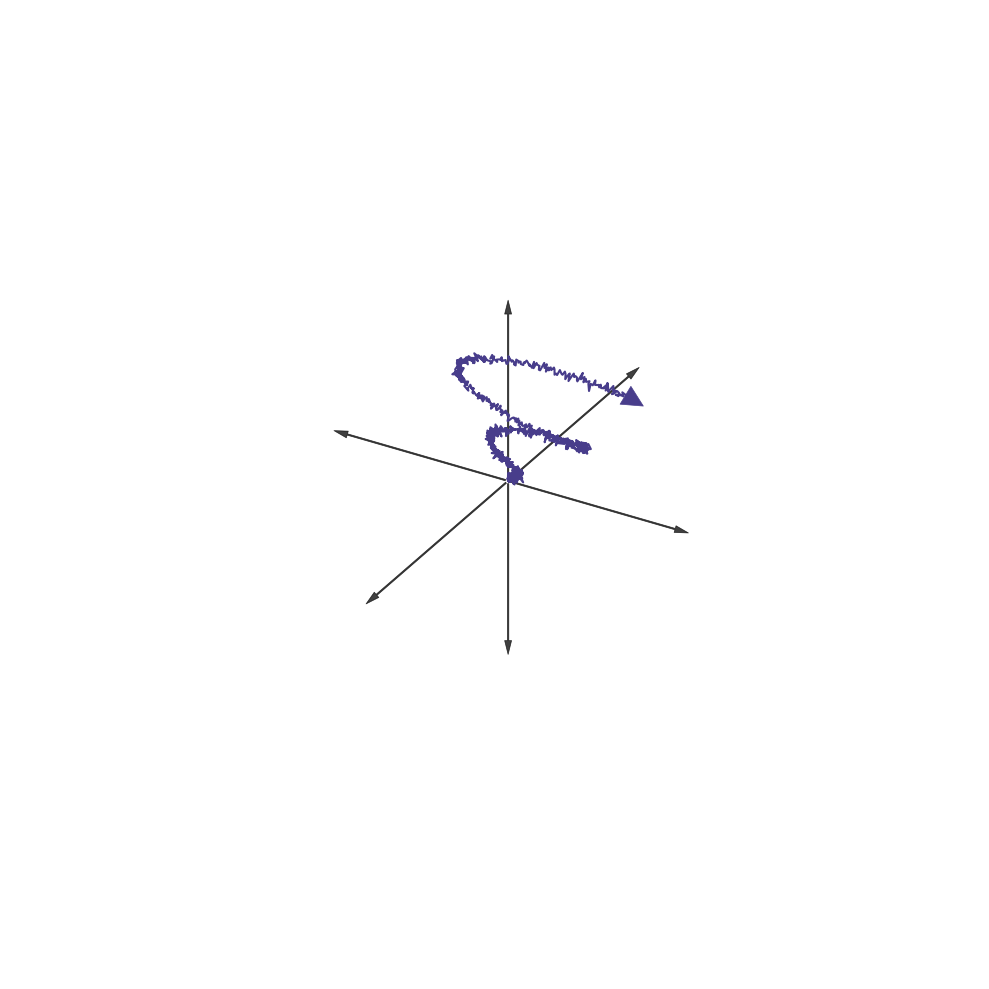

In [10]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.set_box_aspect((1, 1, 1))
# Draw centered axes
#labels = ['Latent Dim 1', 'Latent Dim 2', 'Latent Dim 3']


kwargs = {'color':'k', 'alpha':0.75, 'lw':0.5, 'arrowstyle':ArrowStyle('simple', head_length=2, head_width=1), 'mutation_scale':5}


# x, y, z axes
a = Arrow3D([-0.01, 0.75], [0, 0], [0, 0], **kwargs)
ax.add_artist(a)

a = Arrow3D([0, -0.75], [0, 0], [0, 0], **kwargs)
ax.add_artist(a)


a = Arrow3D([0, 0], [0, -1], [0, 0], **kwargs)
ax.add_artist(a)

a = Arrow3D([0, 0], [0, 1], [0, 0], **kwargs)
ax.add_artist(a)


a = Arrow3D([0, 0], [0, 0], [0, 0.75], **kwargs)
ax.add_artist(a)

a = Arrow3D([0, 0], [0, 0], [0, -0.75], **kwargs)
ax.add_artist(a)

# ax.text(0.75, -0.1, -0.1, 'Latent Dim. 1', fontsize=20)
# ax.text(-0.3, -1.2, -0.1, 'Latent Dim. 2', fontsize=20)
# ax.text(-0.1, 0, -0.9, 'Latent Dim. 3', fontsize=20)

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])

# make the panes transparent
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
# Hide box axesa

ax._axis3don = False

# Noisy open loop trajectory
t, yt, d = gen_trajectory(0.025, 1000)

yt /= 2.5
d /= 2.5
ax.plot(yt[:-25, 0], yt[:-25, 1], yt[:-25, 2], color='darkslateblue', alpha=1.)
#ax.plot(d[:, 0], d[:, 1], d[:, 2], color='r')

kwargs = {'color':'darkslateblue', 'alpha':1., 'lw':0.5, 'arrowstyle':ArrowStyle('simple', head_length=15, head_width=15), 'mutation_scale':1}

# Plot an arrow at the end of the trajectory
a = Arrow3D([d[-3, 0], d[-2, 0]], [d[-3, 1], d[-2, 1]], [d[-3, 2], d[-2, 2]], **kwargs)
ax.add_artist(a)
ax.set_xlim(np.array([-1,1]))
ax.set_ylim(np.array([-1,1]))
ax.set_zlim(np.array([-1,1]))

fig.tight_layout()
#fig.savefig('noisytrajectory.pdf', bbox_inches='tight', pad_inches=0)

In [11]:
# Plot 2D projections of the trajectory
# Projection 1: Literally run PCA
# Projection 2: Literally run FCCA (?)
m1 = PCA(n_components=1).fit(yt)
m2 = LQGCA(T=3, d=1).fit(yt)

In [12]:
V1 = m1.components_.T
V2 = m2.coef_

In [85]:
t = np.linspace(0, 0.1 + np.pi, 1000)
ad = 3
ar = 0.4
ytp = ad * ar/(ar - ad) * (np.exp(-ad * t**2) - np.exp(-ar * t**2))
print(ad * ar/(ar - ad))
#ytp = np.sin(t)[:, np.newaxis]

-0.46153846153846156


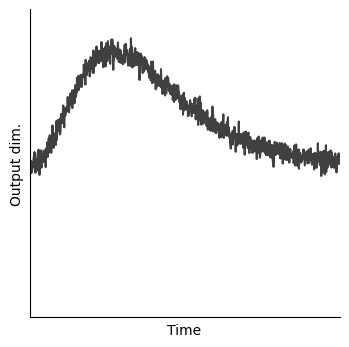

In [89]:
fig, ax = plt.subplots(figsize=(4, 4))
# Artificially make the trace a bit noisy:
yproj = ytp + np.random.normal(scale=0.015, size=(ytp.shape[0],))
#yproj = ytp
ax.plot(yproj, color='k', alpha=0.75)
ax.set_xlim([0, 1000])
#ax.set_xlim([0, 750])
ax.set_ylim([-0.4, 0.4])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks([])
ax.set_yticks([])
ax.set_ylabel('Output dim.')
ax.set_xlabel('Time')
# ax.plot((1), (0), ls="", marker=">", ms=10, color="k",
#         transform=ax.get_yaxis_transform(), clip_on=False)
# ax.plot((0), (1), ls="", marker="^", ms=10, color="k",
#         transform=ax.get_xaxis_transform(), clip_on=False)
fig.savefig('PCAproj.pdf', bbox_inches='tight', pad_inches=0)

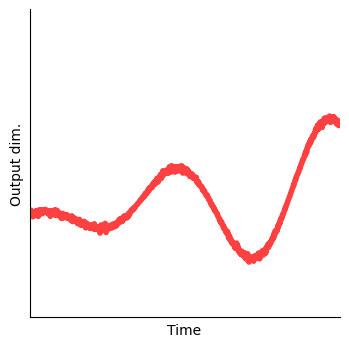

In [15]:
fig, ax = plt.subplots(figsize=(4, 4))
# Artificially make the trace a bit noisy:
yproj = yt @ V2
ax.plot(-0.5*yproj, color='r', alpha=0.75, lw=4)
ax.set_xlim([0, 1000])
ax.set_ylim([-0.25, 0.5])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks([])
ax.set_yticks([])
ax.set_ylabel('Output dim.')
ax.set_xlabel('Time')
# ax.plot((1), (0), ls="", marker=">", ms=10, color="k",
#         transform=ax.get_yaxis_transform(), clip_on=False)
# ax.plot((0), (1), ls="", marker="^", ms=10, color="k",
#         transform=ax.get_xaxis_transform(), clip_on=False)
fig.savefig('FCCAproj_thick.pdf', bbox_inches='tight', pad_inches=0)

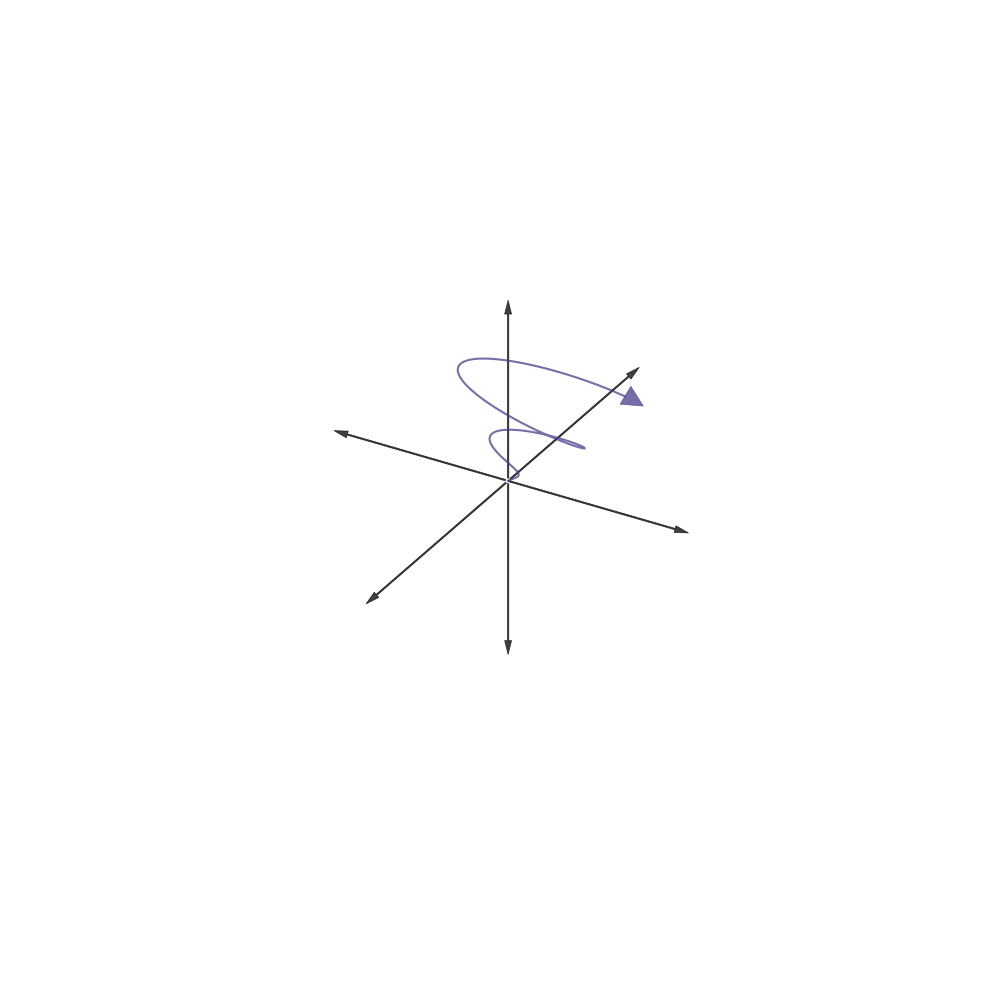

In [9]:
# Plot the denoised version of the trajectory
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.set_box_aspect((1, 1, 1))
# Draw centered axes
#labels = ['Latent Dim 1', 'Latent Dim 2', 'Latent Dim 3']


kwargs = {'color':'k', 'alpha':0.75, 'lw':0.5, 'arrowstyle':ArrowStyle('simple', head_length=2, head_width=1), 'mutation_scale':5}


# x, y, z axes
a = Arrow3D([-0.01, 0.75], [0, 0], [0, 0], **kwargs)
ax.add_artist(a)

a = Arrow3D([0, -0.75], [0, 0], [0, 0], **kwargs)
ax.add_artist(a)


a = Arrow3D([0, 0], [0, -1], [0, 0], **kwargs)
ax.add_artist(a)

a = Arrow3D([0, 0], [0, 1], [0, 0], **kwargs)
ax.add_artist(a)


a = Arrow3D([0, 0], [0, 0], [0, 0.75], **kwargs)
ax.add_artist(a)

a = Arrow3D([0, 0], [0, 0], [0, -0.75], **kwargs)
ax.add_artist(a)

# ax.text(0.75, -0.1, -0.1, 'Latent Dim. 1', fontsize=20)
# ax.text(-0.3, -1.2, -0.1, 'Latent Dim. 2', fontsize=20)
# ax.text(-0.1, 0, -0.9, 'Latent Dim. 3', fontsize=20)

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])

# make the panes transparent
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
# Hide box axesa

ax._axis3don = False

# Noisy open loop trajectory
t, yt, d = gen_trajectory(0.025, 1000)

yt /= 2.5
d /= 2.5
#ax.plot(yt[:-25, 0], yt[:-25, 1], yt[:-25, 2], color='#6433f5', alpha=0.75)
ax.plot(d[:-25, 0], d[:-25, 1], d[:-25, 2], color='darkslateblue', alpha=0.75)

kwargs = {'color':'darkslateblue', 'alpha':0.75, 'lw':0.5, 'arrowstyle':ArrowStyle('simple', head_length=15, head_width=15), 'mutation_scale':1}

# Plot an arrow at the end of the trajectory
a = Arrow3D([d[-3, 0], d[-2, 0]], [d[-3, 1], d[-2, 1]], [d[-3, 2], d[-2, 2]], **kwargs)
ax.add_artist(a)
ax.set_xlim(np.array([-1,1]))
ax.set_ylim(np.array([-1,1]))
ax.set_zlim(np.array([-1,1]))

fig.tight_layout()
fig.savefig('denoisedtrajectory2.pdf', bbox_inches='tight', pad_inches=0)